<a href="https://colab.research.google.com/github/igorsvetlov88/bank-loan-classification/blob/main/bank_loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression # Регрессия
from sklearn.tree import DecisionTreeClassifier # Дерево решений
from sklearn.ensemble import RandomForestClassifier # Случайный лес

In [2]:
df = pd.read_csv("/content/Loan_approval_data_2025.csv")

print(f"Размер датасета: {df.shape}")


df.head()

Размер датасета: (50000, 20)


,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST100000,40,Employed,17.2,25579,692,5.3,895,10820,0,0,0,Credit Card,Business,600,17.02,0.423,0.023,0.008,1
1,CUST100001,33,Employed,7.3,43087,627,3.5,169,16550,0,1,0,Personal Loan,Home Improvement,53300,14.10,0.384,1.237,0.412,0
2,CUST100002,42,Student,1.1,20840,689,8.4,17,7852,0,0,0,Credit Card,Debt Consolidation,2100,18.33,0.377,0.101,0.034,1
3,CUST100003,53,Student,0.5,29147,692,9.8,1480,11603,0,1,0,Credit Card,Business,2900,18.74,0.398,0.099,0.033,1
4,CUST100004,32,Employed,12.5,63657,630,7.2,209,12424,0,0,0,Personal Loan,Education,99600,13.92,0.195,1.565,0.522,1


In [18]:
print("Пропущенные значения:")
print(df.isnull().sum())

Пропущенные значения:
age                        0
occupation_status          0
years_employed             0
annual_income              0
credit_score               0
credit_history_years       0
savings_assets             0
current_debt               0
defaults_on_file           0
delinquencies_last_2yrs    0
derogatory_marks           0
product_type               0
loan_intent                0
loan_amount                0
interest_rate              0
debt_to_income_ratio       0
loan_to_income_ratio       0
payment_to_income_ratio    0
loan_status                0
dtype: int64


In [19]:
print("Распределение целевого признака:")
print(df['loan_status'].value_counts(normalize=True))

print("\nПросмотр категориальных признаков:")
for col in ['occupation_status', 'product_type', 'loan_intent']:
    print(df[col].value_counts())

Распределение целевого признака:
loan_status
1    0.55046
0    0.44954
Name: proportion, dtype: float64

Просмотр категориальных признаков:
occupation_status
Employed         34971
Self-Employed    10179
Student           4850
Name: count, dtype: int64
product_type
Credit Card       22455
Personal Loan     17523
Line of Credit    10022
Name: count, dtype: int64
loan_intent
Personal              12429
Education             10134
Medical                7598
Business               7469
Home Improvement       7453
Debt Consolidation     4917
Name: count, dtype: int64


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      50000 non-null  int64  
 1   occupation_status        50000 non-null  object 
 2   years_employed           50000 non-null  float64
 3   annual_income            50000 non-null  int64  
 4   credit_score             50000 non-null  int64  
 5   credit_history_years     50000 non-null  float64
 6   savings_assets           50000 non-null  int64  
 7   current_debt             50000 non-null  int64  
 8   defaults_on_file         50000 non-null  int64  
 9   delinquencies_last_2yrs  50000 non-null  int64  
 10  derogatory_marks         50000 non-null  int64  
 11  product_type             50000 non-null  object 
 12  loan_intent              50000 non-null  object 
 13  loan_amount              50000 non-null  int64  
 14  interest_rate         

In [6]:
df.describe()

,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.957060,7.454868,50062.892040,643.614820,8.168274,3595.619400,14290.442220,0.053480,0.55464,0.147640,33041.874000,15.498591,0.285724,0.701999,0.233995,0.550460
std,11.118603,7.612097,32630.501014,64.731518,7.207552,13232.399398,13243.757493,0.224991,0.84505,0.412996,26116.185102,4.067942,0.159787,0.465788,0.155268,0.497452
min,18.000000,0.000000,15000.000000,348.000000,0.000000,0.000000,60.000000,0.000000,0.00000,0.000000,500.000000,6.000000,0.002000,0.008000,0.003000,0.000000
25%,26.000000,1.300000,27280.500000,600.000000,2.000000,130.000000,5581.000000,0.000000,0.00000,0.000000,12300.000000,12.180000,0.161000,0.333000,0.111000,0.000000
50%,35.000000,4.900000,41607.500000,643.000000,6.100000,568.000000,10385.000000,0.000000,0.00000,0.000000,26100.000000,15.440000,0.265000,0.622000,0.207000,1.000000
75%,43.000000,11.400000,62723.250000,687.000000,12.600000,2271.000000,18449.250000,0.000000,1.00000,0.000000,48500.000000,18.870000,0.389000,1.010250,0.337000,1.000000
max,70.000000,39.900000,250000.000000,850.000000,30.000000,300000.000000,163344.000000,1.000000,9.00000,4.000000,100000.000000,23.000000,0.800000,2.001000,0.667000,1.000000


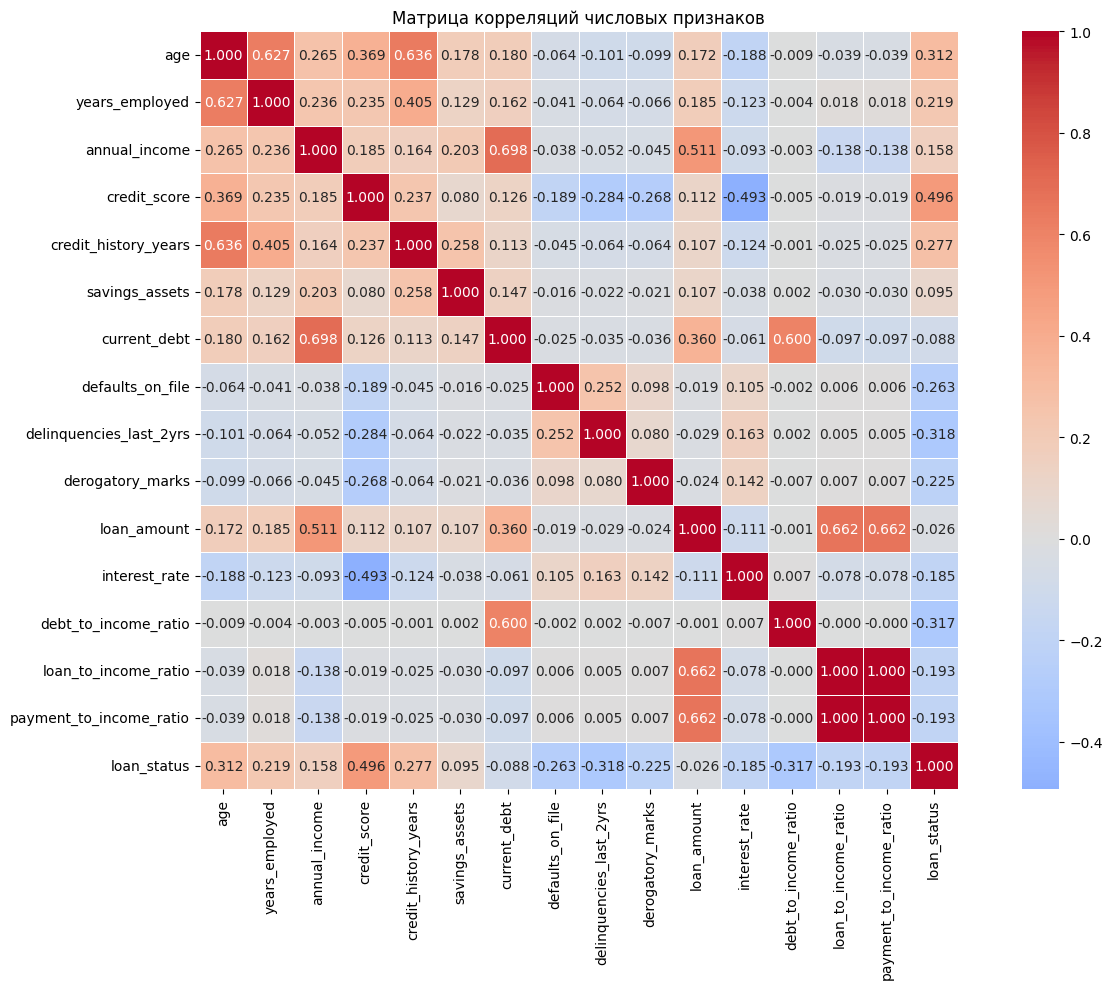

In [21]:
numeric_df = df.select_dtypes(include=["int64", "float64"])
numeric_df.head()

# Создаем корреляционную матрицу
correlation_matrix = numeric_df.corr()

# Визуализация
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', linewidths=0.5)
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

In [8]:
corr_target = correlation_matrix["loan_status"].sort_values(ascending=False)
corr_target


,loan_status
loan_status,1.000000
credit_score,0.496316
age,0.311524
credit_history_years,0.277103
years_employed,0.218875
annual_income,0.158466
savings_assets,0.094789
loan_amount,-0.025987
current_debt,-0.088494
interest_rate,-0.185179


In [23]:
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [25]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])


In [30]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


In [31]:
n_estimators_list = [10, 25, 50, 75, 100, 150, 200, 300]

roc_auc_scores = []

for n in n_estimators_list:
    model = Pipeline([
        ("preprocess", preprocess),
        ("rf", RandomForestClassifier(
            n_estimators=n,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ))
    ])

    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="roc_auc"
    )

    roc_auc_scores.append(scores.mean())

    print(f"n_estimators={n}, ROC-AUC={scores.mean():.4f}")


n_estimators=10, ROC-AUC=0.9638
n_estimators=25, ROC-AUC=0.9670
n_estimators=50, ROC-AUC=0.9679
n_estimators=75, ROC-AUC=0.9682
n_estimators=100, ROC-AUC=0.9685
n_estimators=150, ROC-AUC=0.9687
n_estimators=200, ROC-AUC=0.9688
n_estimators=300, ROC-AUC=0.9690


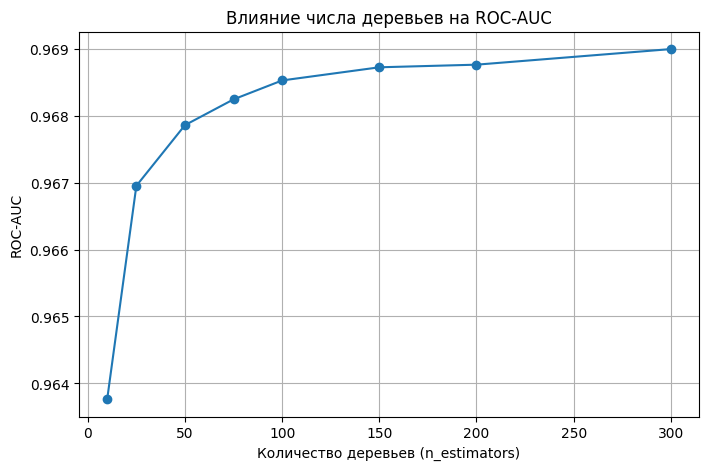

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, roc_auc_scores, marker="o")
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel("ROC-AUC")
plt.title("Влияние числа деревьев на ROC-AUC")
plt.grid(True)
plt.show()


In [33]:
best_n = n_estimators_list[np.argmax(roc_auc_scores)]
best_score = max(roc_auc_scores)

print(f"Лучшее n_estimators: {best_n}")
print(f"ROC-AUC: {best_score:.4f}")


Лучшее n_estimators: 300
ROC-AUC: 0.9690


In [28]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42) # взял 50 так как разница между 50 и 300 ~  0.001, но время выполнения гораздо больше чем больше число
}

results = []

for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    results.append({"Model": name, "Accuracy": acc})

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))



Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4495
           1       0.87      0.89      0.88      5505

    accuracy                           0.87     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.87      0.87      0.87     10000


Decision Tree
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4495
           1       0.84      0.90      0.87      5505

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Random Forest
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4495
           1       0.92      0.92      0.92      5505

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91

In [13]:
best_model_name = "Random Forest"
best_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", models[best_model_name])
])

best_pipe.fit(X_train, y_train)

# Сохранение
joblib.dump(best_pipe, 'rf_model.pkl')

['rf_model.pkl']